In [567]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [568]:
def plot_hist(ax, data, bins=24, title="gauss hist"):

    ax.hist(data, normed=True, bins=bins)
    ax.set_title(title)

### Get the data set

In [569]:
df = pd.read_csv('eurotunnel_3_months.csv', index_col=False, header=0);

#### check what is all about

In [570]:
df.head()

,terminal,servicetype,departures,waitingtimeminutes,journeytimeminutes,delayreason,retrievaldate,latitude,longitude,trend
0,UK,normal,6,0,60,none/unknown,2018-02-01 00:13:06.432,51.0963,1.13505,stable
1,F,normal,4,0,60,none/unknown,2018-02-01 00:13:06.57,50.9239,1.81604,stable
2,UK,normal,6,0,60,none/unknown,2018-02-01 00:42:53.941,51.0963,1.13505,stable
3,F,normal,5,0,60,none/unknown,2018-02-01 00:42:54.08,50.9239,1.81604,stable
4,UK,normal,4,0,60,none/unknown,2018-02-01 01:12:54.094,51.0963,1.13505,stable


### Try to get some insight on the data

In [571]:
# defensive measures
print(len(df[df['waitingtimeminutes']==90]))

# check for imbalancement

fr = df[df['terminal'] == "F"]
uk = df[df['terminal'] == "UK"]
print(len(fr), len(uk))

118
4259 4259


#### CHECK DELAY DISTRIBUTION

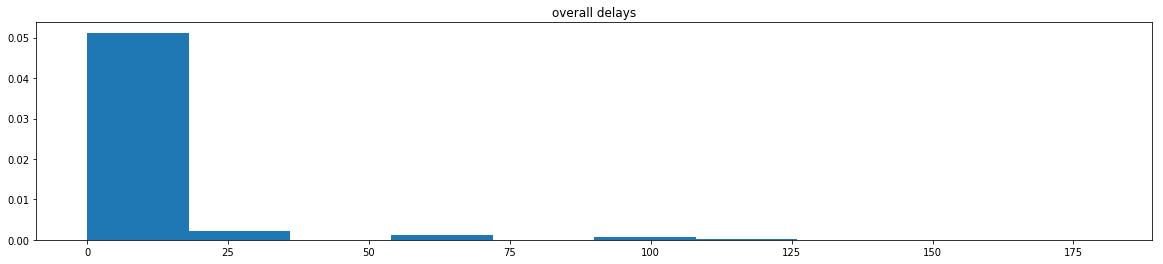

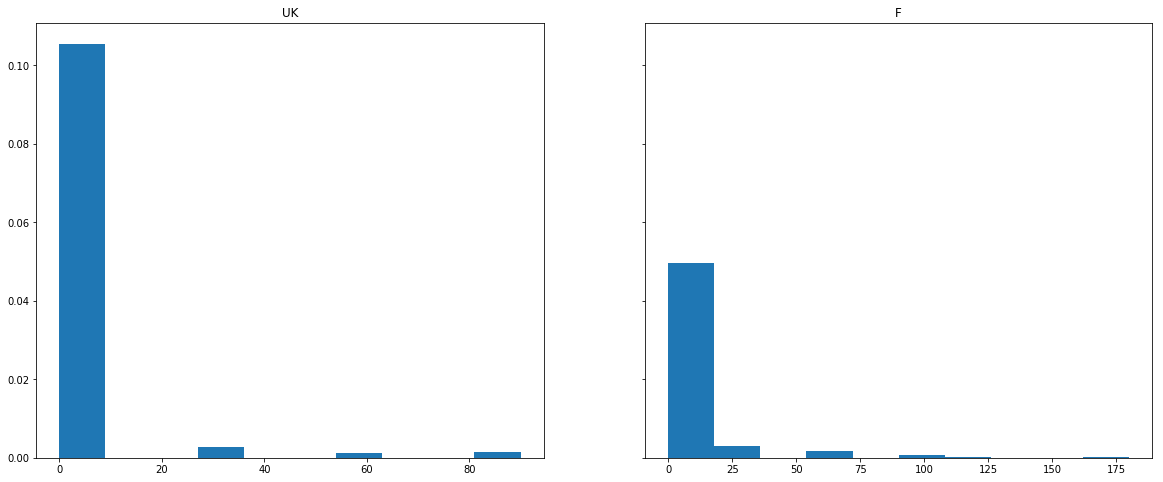

In [572]:
delays    = df['waitingtimeminutes']
delays_UK = df[df['terminal']=='UK']['waitingtimeminutes']
delays_FR = df[df['terminal']=='F']['waitingtimeminutes']

fig, ax = plt.subplots(sharey=True, figsize=(20,4))
plot_hist(ax,  delays,    bins=10, title="overall delays")

fig, (ax_uk, ax_fr) = plt.subplots(1, 2, sharey=True, figsize=(20,8))
plot_hist(ax_uk, delays_UK, bins=10, title="UK")
plot_hist(ax_fr, delays_FR, bins=10, title="F")

##### Apparently there is not much delays, the frech side has more and longer ones. Check a bit just in case

In [573]:
cntuk = len(delays_UK[delays_UK==0])
cntfr = len(delays_FR[delays_FR==0])
cnt   = len(delays[delays==0])

_df = pd.DataFrame(data={'all':[cnt], 'UK':[cntuk], 'FR':[cntfr]})
_df

,FR,UK,all
0,3803,4045,7848


##### All seems in order, data is consistent

### Lets figure a Hipotesis: "delays are dependent on some TIME factors like day of week" and of course, the tunnel end

In [574]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import datetime

df['dow'] = df.apply(lambda row: datetime.datetime.strptime(row['retrievaldate'][0:19], '%Y-%m-%d %H:%M:%S').weekday(), axis=1)
df['idterminal'] = df.apply(lambda row: 1 if row['terminal']=='UK' else 2, axis=1)

In [575]:
df.head()

,terminal,servicetype,departures,waitingtimeminutes,journeytimeminutes,delayreason,retrievaldate,latitude,longitude,trend,dow,idterminal
0,UK,normal,6,0,60,none/unknown,2018-02-01 00:13:06.432,51.0963,1.13505,stable,3,1
1,F,normal,4,0,60,none/unknown,2018-02-01 00:13:06.57,50.9239,1.81604,stable,3,2
2,UK,normal,6,0,60,none/unknown,2018-02-01 00:42:53.941,51.0963,1.13505,stable,3,1
3,F,normal,5,0,60,none/unknown,2018-02-01 00:42:54.08,50.9239,1.81604,stable,3,2
4,UK,normal,4,0,60,none/unknown,2018-02-01 01:12:54.094,51.0963,1.13505,stable,3,1


In [576]:
df_UK = df[df['terminal']=='UK']
df_FR = df[df['terminal']=='F']

reg = np.array([df['idterminal'], df['dow'], df['waitingtimeminutes']]).transpose()
reg_UK = np.array([df_UK['idterminal'], df_UK['dow'], df_UK['waitingtimeminutes']]).transpose()
reg_FR = np.array([df_FR['idterminal'], df_FR['dow'], df_FR['waitingtimeminutes']]).transpose()

In [578]:
def scatter_plot_1(reg, reg_UK, reg_FR, scaled=False, marker='x', color='b'):
    
    _min = min(reg[:,2])
    _max = max(reg[:,2])
    if scaled:
        s = [(n + 1000)/(n+1) for n in range(len(x))]
    else:
        s = 50
    
    _max = max(reg[:,2]) + 25
    plt.subplots(1, 3, sharey=True, figsize=(20,20))
    plt.subplot(331)
    plt.ylim(-10, _max)
    plt.scatter(reg_UK[:,1], reg_UK[:,2], s=s, color=color, marker=marker)
    plt.grid()
    plt.title("dow, delay scatter UK")

    plt.subplot(332)
    plt.ylim(-10, _max)
    plt.scatter(reg_FR[:,1], reg_FR[:,2], s=s, color=color, marker=marker)
    plt.grid()
    plt.title("dow, delay scatter FR")

    plt.subplot(333)
    plt.ylim(-10, _max)
    plt.scatter(reg[:,1], reg[:,2], s=s, color=color, marker=marker)
    plt.grid()
    plt.title("dow, delay scatter ALL")


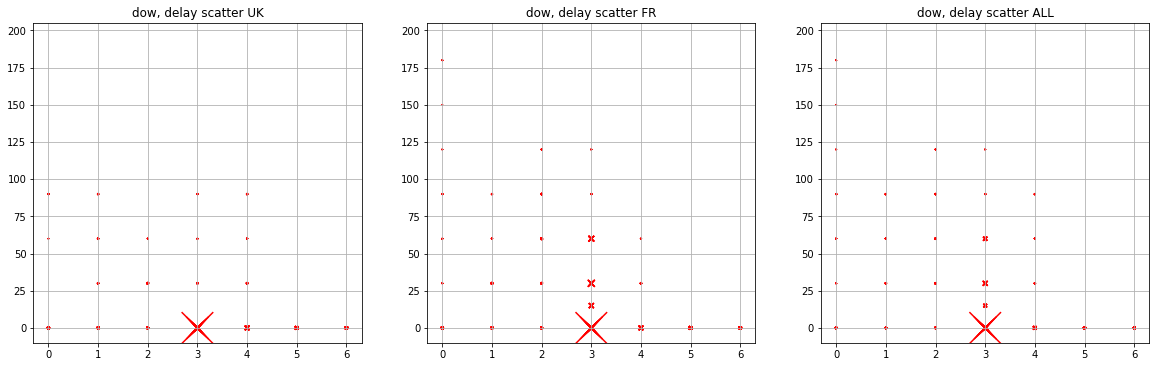

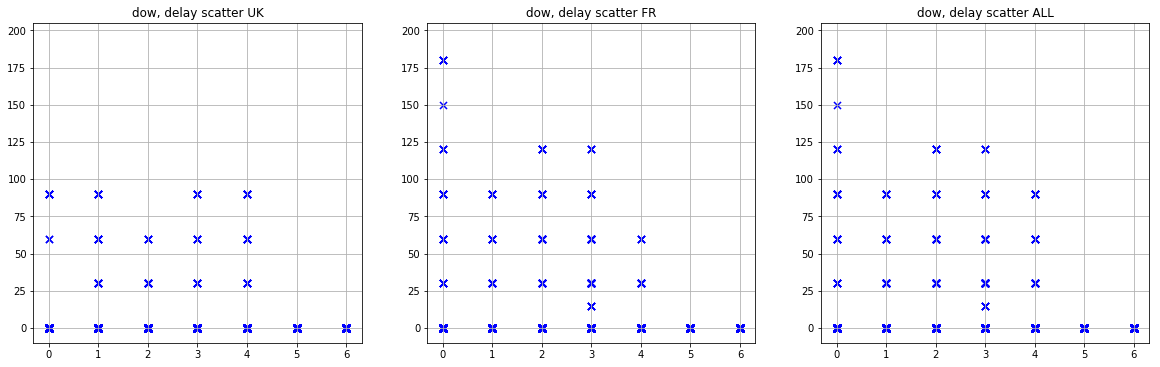

In [579]:
scatter_plot_1(reg, reg_UK, reg_FR, scaled=True, marker='x', color='r')
scatter_plot_1(reg, reg_UK, reg_FR, scaled=False)

#### THE HIPOTESIS SEEMS TRUE, THE DAY OF WEEK HAS SOMETHING TO DO WITH DELAYS, FOR EXAMPLE, FRANCE HAS A LOT OF DELAYS ON SUNDAY

####Can be a spurious correlation, lets check sundays distribution. Then I will try to correlate with the other end, something is fishy here, how its possible that a delay on France do not affect UK end ?!

In [580]:
dist = df.loc[(df['idterminal']==2) & (df['dow']==0)]
dist

,terminal,servicetype,departures,waitingtimeminutes,journeytimeminutes,delayreason,retrievaldate,latitude,longitude,trend,dow,idterminal
389,F,normal,4,0,60,none/unknown,2018-02-05 00:13:12.218,50.9239,1.81604,stable,0,2
391,F,normal,2,0,60,none/unknown,2018-02-05 00:42:56.006,50.9239,1.81604,stable,0,2
393,F,normal,2,0,60,none/unknown,2018-02-05 01:12:57.035,50.9239,1.81604,stable,0,2
395,F,normal,5,0,60,none/unknown,2018-02-05 01:42:54.838,50.9239,1.81604,stable,0,2
397,F,normal,2,0,60,none/unknown,2018-02-05 02:13:05.202,50.9239,1.81604,stable,0,2
399,F,delayed,4,0,120,none/unknown,2018-02-05 02:42:54.302,50.9239,1.81604,increasing,0,2
401,F,delayed,5,0,120,none/unknown,2018-02-05 03:12:55.796,50.9239,1.81604,stable,0,2
403,F,delayed,4,0,120,none/unknown,2018-02-05 03:42:54.906,50.9239,1.81604,stable,0,2
405,F,delayed,4,0,120,none/unknown,2018-02-05 04:13:11.169,50.9239,1.81604,stable,0,2
407,F,delayed,4,0,120,none/unknown,2018-02-05 04:42:55.803,50.9239,1.81604,stable,0,2


array([ 0,  0,  0, ..., 60, 60, 60])

### LETS DO THE SAME WITH THE NUMBER OF DEPARTURES - MAYBE HAS SOMETHING TO DO

In [342]:
reg_d = np.array([df['idterminal'], df['departures'], df['waitingtimeminutes']]).transpose()
reg_UK_d = np.array([df_UK['idterminal'], df_UK['departures'], df_UK['waitingtimeminutes']]).transpose()
reg_FR_d = np.array([df_FR['idterminal'], df_FR['departures'], df_FR['waitingtimeminutes']]).transpose()

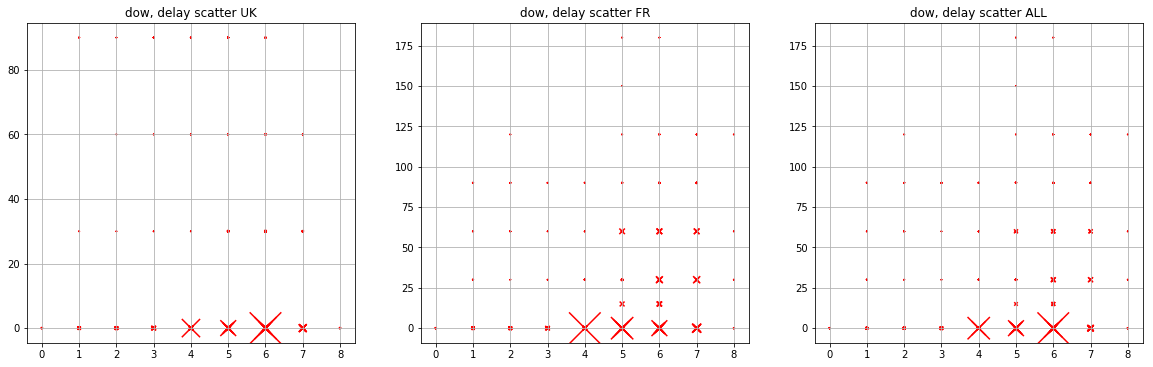

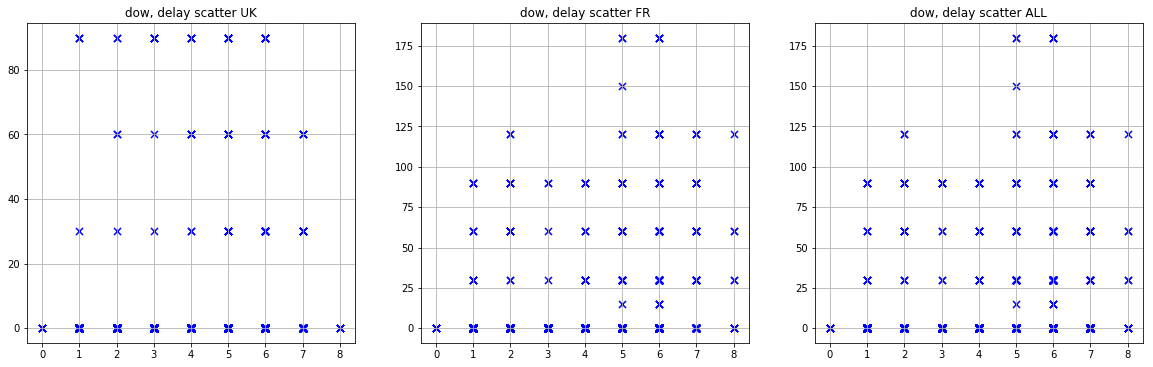

In [531]:
scatter_plot_1(reg_d, reg_UK_d, reg_FR_d, scaled=True, marker='x', color='r')
scatter_plot_1(reg_d, reg_UK_d, reg_FR_d, scaled=False)

### Apparently not a many relevant one, there are some delays with 6 departures on France, while UK has consistent delays. - OF COURSE there is some knowlegde here and we need to explore it further -

### NOW we need to correlate the to features, day of week and number of departures

In [349]:
### JUST PUT ALL TOGETHER TO MAKE OUR POINT CLEAR

In [286]:
db = DBSCAN(eps=0.3, min_samples=10).fit(reg)

In [292]:
labels = db.labels_
n_clusters_ = np.max(db.labels_) + 1

In [293]:
n_clusters_

36

In [316]:
reg[1,:]

array([2, 3, 0])

In [310]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [355]:
reg_FR

array([[ 2,  3,  0],
       [ 2,  3,  0],
       [ 2,  3,  0],
       ...,
       [ 2,  0, 60],
       [ 2,  0, 60],
       [ 2,  0, 60]])

In [ ]:
    km = KMeans(n_clusters=21).fit(reg)
    labels = km.labels_

